## Описание проекта

Задача проекта - разработать предсказательную модель температуры расплавленного состояния сплава, которая поспособствует бизнесу в работе над своими издержками.

Метрика качества модели - MAE (mean absolute error)

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Импортируем необходимые библиотеки.

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn
import optuna

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

## Исследовательский анализ данных

In [298]:
data_arc = pd.read_csv('C:/Users/User/Desktop/123/final_steel/data_arc.csv')
data_bulk = pd.read_csv('C:/Users/User/Desktop/123/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('C:/Users/User/Desktop/123/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('C:/Users/User/Desktop/123/final_steel/data_gas.csv')
data_temp = pd.read_csv('C:/Users/User/Desktop/123/final_steel/data_temp.csv')
data_wire = pd.read_csv('C:/Users/User/Desktop/123/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('C:/Users/User/Desktop/123/final_steel/data_wire_time.csv')

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Pезультаты измерения температуры

In [4]:
display(data_temp.head(7))
display(data_temp.info())
display(data_temp.describe())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Есть почти 3000 пропусков. 

<AxesSubplot:>

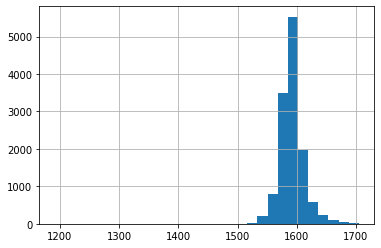

In [5]:
data_temp['Температура'].hist(bins=30)

<AxesSubplot:>

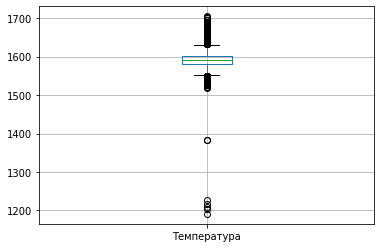

In [6]:
data_temp[['Температура']].boxplot()

In [7]:
a1 = data_temp[data_temp['Температура']<1630]
a1 = a1[a1['Температура']>1550]
len(set(a1.key))

3079

162 партии, в которых в значениях температуры есть выбросы. Так как значения температуры, это целевой признак, все партии, где есть выбросы и нет измерений температуры (или есть, но 1), мы удалим, чтобы признак был максимально "чист". 

Выбросами будем считать все, что больше *q_3 + 3 * irq* (как посоветовал тимлид). В данном случае, *iqr = 1601-1581= 20.* Верхний порог будет 1601+3 * 20=1661. И удалим партии с пропусками.

In [8]:
data_temp = data_temp.fillna(0)
cnd = []
for i in range(len(data_temp)):
    if data_temp['Температура'][i]>1661 or data_temp['Температура'][i]<1500 or data_temp['Температура'][i]==0:
        cnd.append(data_temp['key'][i])

In [9]:
bad_part = list(set(cnd))
len(bad_part)

776

In [10]:
data_temp = data_temp.query("key not in @bad_part")
len(data_temp)

12052

И удалим партии, где одно значение температуры

In [11]:
a1 = [x for x in list(data_temp.key) if list(data_temp.key).count(x) == 1]
a1

[195, 279]

In [12]:
data_temp = data_temp[data_temp['key']!=195]
data_temp = data_temp[data_temp['key']!=279]

Целевым признаком у нашей модели будет последнее значение температуры по партии(key). В качестве целевого признака можно использовать первое значение температуры по партии. Оставим только первый и последний замер температуры, как целевой признак и признак

In [13]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')
data_temp_time = data_temp.pivot_table(index='key', values='Время замера', aggfunc='min')

In [14]:
data_temp_feature = pd.merge(data_temp_time, data_temp, how='left', on='Время замера')
data_temp_feature = data_temp_feature.drop('Время замера', axis=1)
data_temp_feature.columns = ['key', 'temp_feature']
data_temp_feature.head()

,key,temp_feature
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0


In [15]:
data_temp_time_max = data_temp.pivot_table(index='key', values='Время замера', aggfunc='max')

In [16]:
data_temp_target = pd.merge(data_temp_time_max, data_temp, how='left', on='Время замера')
data_temp_target = data_temp_target.drop('Время замера', axis=1)
data_temp_target.columns = ['key', 'temp_target']
data_temp_target.head()

,key,temp_target
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0


In [17]:
data_temp_new = pd.merge(data_temp_target, data_temp_feature, on='key')
data_temp_new.head()

,key,temp_target,temp_feature
0,1,1613.0,1571.0
1,2,1602.0,1581.0
2,3,1599.0,1596.0
3,4,1625.0,1601.0
4,5,1602.0,1576.0


### Данные об электродах

In [18]:
display(data_arc.head(7))
display(data_arc.info())
display(data_arc.describe())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В таблице нет пропусков. Минимальное значение реактивной мощности сильно меньше максимальной. Это похоже на выброс.

<AxesSubplot:>

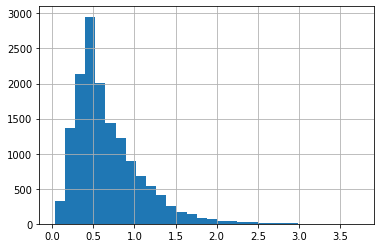

In [19]:
data_arc['Активная мощность'].hist(bins=30)

<AxesSubplot:>

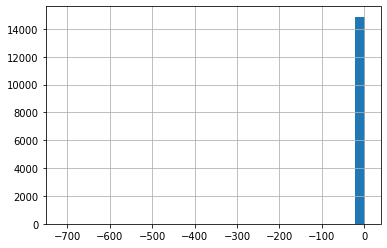

In [20]:
data_arc['Реактивная мощность'].hist(bins=30)

<AxesSubplot:>

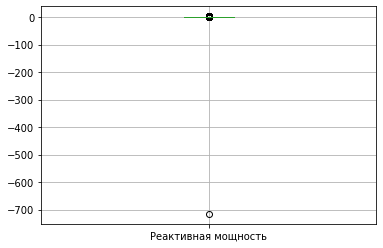

In [21]:
data_arc[['Реактивная мощность']].boxplot()

Да, похоже на аномалию. Необходимо найти номер партии с этим значением реактивной мощности и исключить его из набора данных.

In [22]:
data_arc[data_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Партия номер 2116. 

<AxesSubplot:>

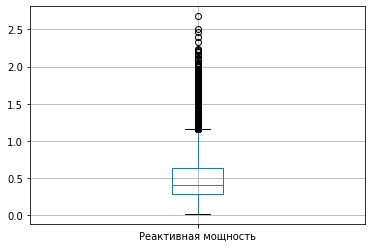

In [23]:
a1 = data_arc[data_arc['Реактивная мощность']>0]
a1[['Реактивная мощность']].boxplot()

In [24]:
len(set(list(data_arc[data_arc['Реактивная мощность']>1.2].key)))

500

In [25]:
str_reakt = list(data_arc[data_arc['Реактивная мощность']>1.2].key)
str_reakt

[6,
 8,
 16,
 21,
 30,
 32,
 44,
 45,
 51,
 51,
 52,
 53,
 54,
 55,
 67,
 77,
 83,
 88,
 99,
 118,
 120,
 123,
 133,
 145,
 146,
 150,
 180,
 189,
 191,
 210,
 211,
 212,
 223,
 241,
 252,
 262,
 263,
 274,
 274,
 275,
 277,
 291,
 291,
 306,
 310,
 312,
 315,
 319,
 321,
 322,
 330,
 331,
 335,
 338,
 340,
 341,
 354,
 360,
 361,
 372,
 375,
 376,
 378,
 385,
 405,
 413,
 414,
 416,
 416,
 419,
 427,
 437,
 437,
 439,
 440,
 441,
 444,
 455,
 460,
 460,
 465,
 475,
 476,
 483,
 508,
 512,
 513,
 519,
 527,
 537,
 538,
 539,
 544,
 547,
 547,
 547,
 549,
 550,
 552,
 552,
 553,
 559,
 580,
 589,
 590,
 606,
 606,
 625,
 628,
 638,
 639,
 640,
 641,
 642,
 650,
 656,
 663,
 666,
 682,
 685,
 685,
 686,
 726,
 727,
 731,
 743,
 747,
 752,
 778,
 791,
 803,
 811,
 813,
 813,
 813,
 814,
 844,
 860,
 861,
 872,
 875,
 877,
 882,
 894,
 903,
 904,
 907,
 908,
 914,
 928,
 929,
 935,
 944,
 948,
 957,
 959,
 1005,
 1024,
 1026,
 1030,
 1032,
 1050,
 1051,
 1057,
 1058,
 1063,
 1087,
 1088,
 

Если реактивная мощность больше 1.2, то это похоже на выброс. Сохраним список партий, в которых, возможно есть выбросы в значениях реактивной мощности - 500 партий.

Посмотрим на данные с активной мощностью.

<AxesSubplot:>

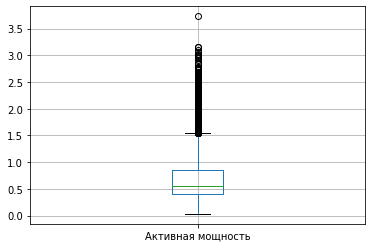

In [26]:
data_arc[['Активная мощность']].boxplot()

In [27]:
len(data_arc[data_arc['Активная мощность']<1.5])

14227

In [28]:
len(set(list(data_arc[data_arc['Активная мощность']>1.5].key)))

586

В данных об активной мощности тоже есть выбросы. Это 586 партий

In [29]:
cnd=0
for i in data_arc.key:
    if i in list(data_arc[data_arc['Активная мощность']>1.5].key):
        cnd+=1
cnd

2994

И 2994 строки. Сравним партии, в которых, возможно, есть выбросы в значениях реактивной мощности, и партии, в которых, возможно, есть выбросы в значениях активной мощности

In [30]:
cnd=0
str_part=[]
for i in list(data_arc[data_arc['Активная мощность']>1.5].key):
    if i in str_reakt:
        cnd+=1
        str_part.append(i)
cnd

496

In [31]:
cnd=0
for i in data_arc.key:
    if i in str_part:
        cnd+=1
cnd

2290

In [32]:
set(str_part)

{6,
 8,
 21,
 30,
 32,
 44,
 45,
 51,
 52,
 53,
 54,
 55,
 67,
 77,
 83,
 88,
 99,
 118,
 120,
 123,
 133,
 145,
 146,
 180,
 189,
 191,
 210,
 211,
 212,
 223,
 241,
 252,
 262,
 263,
 274,
 275,
 291,
 306,
 310,
 312,
 315,
 321,
 322,
 330,
 331,
 335,
 338,
 340,
 341,
 354,
 360,
 361,
 372,
 375,
 376,
 378,
 385,
 405,
 413,
 416,
 427,
 437,
 439,
 440,
 441,
 444,
 455,
 460,
 465,
 475,
 476,
 483,
 508,
 512,
 513,
 527,
 538,
 539,
 544,
 549,
 550,
 553,
 580,
 589,
 590,
 606,
 625,
 628,
 638,
 639,
 640,
 641,
 642,
 650,
 656,
 663,
 666,
 682,
 685,
 686,
 726,
 727,
 731,
 743,
 747,
 752,
 778,
 791,
 803,
 811,
 813,
 814,
 844,
 860,
 861,
 872,
 875,
 882,
 894,
 903,
 904,
 907,
 908,
 914,
 928,
 929,
 935,
 944,
 948,
 957,
 959,
 1005,
 1024,
 1026,
 1030,
 1032,
 1050,
 1051,
 1057,
 1058,
 1063,
 1087,
 1088,
 1090,
 1102,
 1107,
 1118,
 1120,
 1122,
 1143,
 1144,
 1146,
 1147,
 1150,
 1151,
 1163,
 1177,
 1178,
 1185,
 1187,
 1203,
 1205,
 1224,
 1227,
 1

In [33]:
len(set(str_part))

442

У нас 442 партии (2290 строк), в которых есть выборсы в значениях обеих мощностей. Возможно, это и не выбросы. Просто для некоторых партий нужно больше мощности. Сохраним номера этих партий, и посмотрим, будет ли еще какая-то взаимосвязь между этими партиями.

Просуммируем значения мощностей по партиям, чтобы использовать их как признаки и объеденим их с таблицой температуры.

In [34]:
data_arc_new = data_arc.pivot_table(index='key', values=['Активная мощность', 'Реактивная мощность'], aggfunc='sum')
data_arc_new = data_arc_new.reset_index()
data_arc_new.head()

,key,Активная мощность,Реактивная мощность
0,1,4.878147,3.183241
1,2,3.052598,1.998112
2,3,2.525882,1.599076
3,4,3.209250,2.060298
4,5,3.347173,2.252643


In [35]:
data = pd.merge(data_temp_new, data_arc_new, on='key')
data.columns=['key', 'temp_target', 'temp_feature', 'a_power', 'r_power']

Проверим, остались ли партии, которые вызывали сомнения, после объединения таблиц.

In [36]:
cnd = []
for i in data.key:
    if i in list(set(str_part)):
        cnd.append(i)

In [37]:
len(cnd)

319

Остались 319 партий. Пока оставим эти партии, ведь вдруг для их производства нужно больше энергии, чем для других. Проверим партию, в которой значение реактивной мощности было -715. Партия №2116

In [38]:
data[data['r_power']<0]

,key,temp_target,temp_feature,a_power,r_power
2065,2116,1578.0,1579.0,1.848681,-714.591636


Партия осталась. Удалим

In [39]:
data = data[data['r_power']>0]

### Данные о подаче сыпучих материалов

In [40]:
display(data_bulk.head())
display(data_bulk.info())
display(data_bulk.describe())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'Bulk 1'}>,
        <AxesSubplot:title={'center':'Bulk 2'}>,
        <AxesSubplot:title={'center':'Bulk 3'}>],
       [<AxesSubplot:title={'center':'Bulk 4'}>,
        <AxesSubplot:title={'center':'Bulk 5'}>,
        <AxesSubplot:title={'center':'Bulk 6'}>,
        <AxesSubplot:title={'center':'Bulk 7'}>],
       [<AxesSubplot:title={'center':'Bulk 8'}>,
        <AxesSubplot:title={'center':'Bulk 9'}>,
        <AxesSubplot:title={'center':'Bulk 10'}>,
        <AxesSubplot:title={'center':'Bulk 11'}>],
       [<AxesSubplot:title={'center':'Bulk 12'}>,
        <AxesSubplot:title={'center':'Bulk 13'}>,
        <AxesSubplot:title={'center':'Bulk 14'}>,
        <AxesSubplot:title={'center':'Bulk 15'}>]], dtype=object)

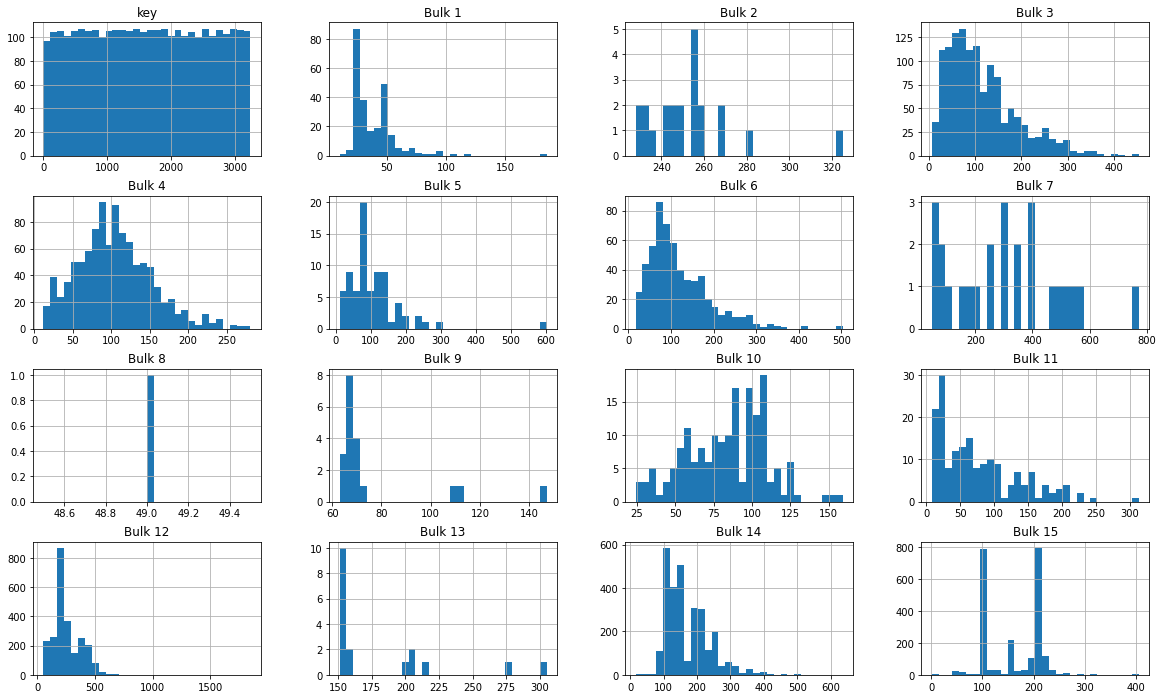

In [41]:
data_bulk.hist(figsize=(20,12), bins=30)

<AxesSubplot:>

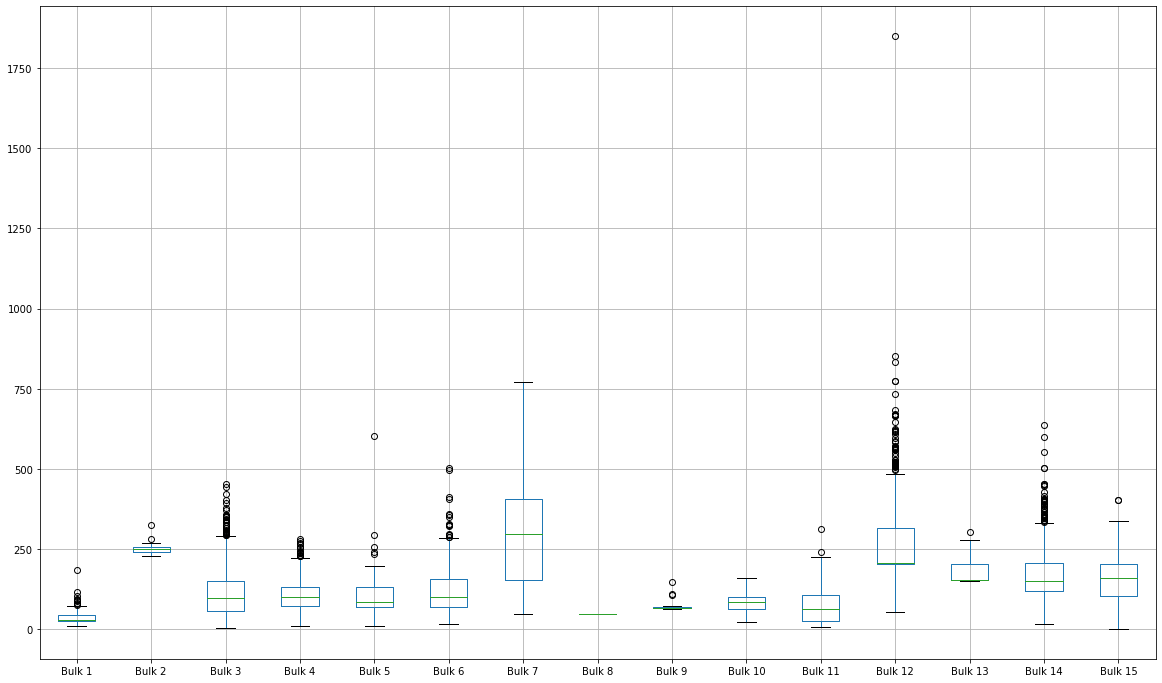

In [42]:
data_bulk.drop(['key'], axis=1).boxplot(figsize=(20,12))

In [43]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В столбце Bulk 12 есть подозрение на выброс. 

В таблице много пропусков, но это тоже несет в себе нужную нам информацию. Там, где в таблице пропуск, значит, что на этом этапе в ковш не добалялись сыпучие материалы. В партиях, в которые ни в одном из этапов не добалялись материалы, нужно будет взять на карандаш, и, скорее всего, убрать. Ведь это будут наши признаки для модели. Пропуски нужно заполнить нулями.

In [44]:
data_bulk = data_bulk[data_bulk['Bulk 12']<1500]

In [45]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Данные о времени добавления сыпучих материалов в обучении модели не участвуют. Принято, что добавки добавляются в хронологическом порядке (было уточннение от тим-лида)

В данных есть момент, где сыпучие материалы добавляются только 1 раз(Bulk 8). Эта партия может помешать обучению модели. Узнаем что за партия, и удалим ее.

In [46]:
data_bulk[data_bulk['Bulk 8']==49.0]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15


Проверим, входит ли эта партия в наши общие данные

In [47]:
data[data['key']==1725]

,key,temp_target,temp_feature,a_power,r_power
1681,1725,1595.0,1593.0,2.598092,2.121671


In [48]:
data=data[data['key']!=1725]

Заполним пропуски нулями и добавим эти данные в общий набор, как признаки.

In [49]:
data_bulk = data_bulk.fillna(0)

In [50]:
data = pd.merge(data, data_bulk, on='key')

### Данные о продувке сплава газом

In [51]:
display(data_gas.head())
display(data_gas.info())
display(data_gas.describe())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Пропусков в таблицах нет. Но подозрительно выглядит максимальное значение

<AxesSubplot:>

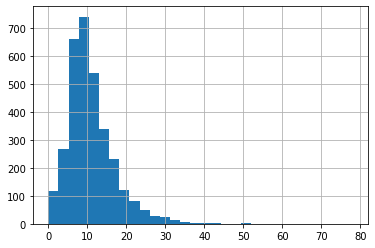

In [52]:
data_gas['Газ 1'].hist(bins=30)

<AxesSubplot:>

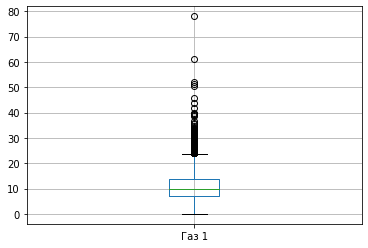

In [53]:
data_gas[['Газ 1']].boxplot()

In [54]:
len(set(list(data_gas[data_gas['Газ 1']>25].key)))

101

101 партия, в которых, возможно, есть выбросы.

In [55]:
cnd=0
for i in set(list(data_gas[data_gas['Газ 1']>25].key)):
    if i in str_part:
        cnd+=1
cnd

22

22 из этих партий есть в партиях, в которых завышены значения мощностей.

In [56]:
data_gas.columns=['key', 'gas']

In [57]:
data = pd.merge(data, data_gas, on='key')

In [58]:
data

,key,temp_target,temp_feature,a_power,r_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas
0,1,1613.0,1571.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1602.0,1581.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1599.0,1596.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1625.0,1601.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1602.0,1576.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,2495,1591.0,1570.0,3.210690,2.360777,0.0,0.0,21.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
1852,2496,1591.0,1554.0,4.203064,2.810185,0.0,0.0,0.0,63.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
1853,2497,1589.0,1571.0,2.212379,1.851269,0.0,0.0,0.0,85.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
1854,2498,1594.0,1591.0,3.408725,2.355428,0.0,0.0,90.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


<AxesSubplot:>

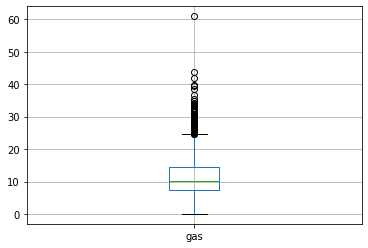

In [59]:
data[['gas']].boxplot()

Партия с выбросом ушла.

### Данные о проволочных материалах

In [60]:
display(data_wire.head())
display(data_wire.info())
display(data_wire.describe())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Не для всех партий есть данные о проволочных материалах.

array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'Wire 1'}>,
        <AxesSubplot:title={'center':'Wire 2'}>],
       [<AxesSubplot:title={'center':'Wire 3'}>,
        <AxesSubplot:title={'center':'Wire 4'}>,
        <AxesSubplot:title={'center':'Wire 5'}>],
       [<AxesSubplot:title={'center':'Wire 6'}>,
        <AxesSubplot:title={'center':'Wire 7'}>,
        <AxesSubplot:title={'center':'Wire 8'}>],
       [<AxesSubplot:title={'center':'Wire 9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

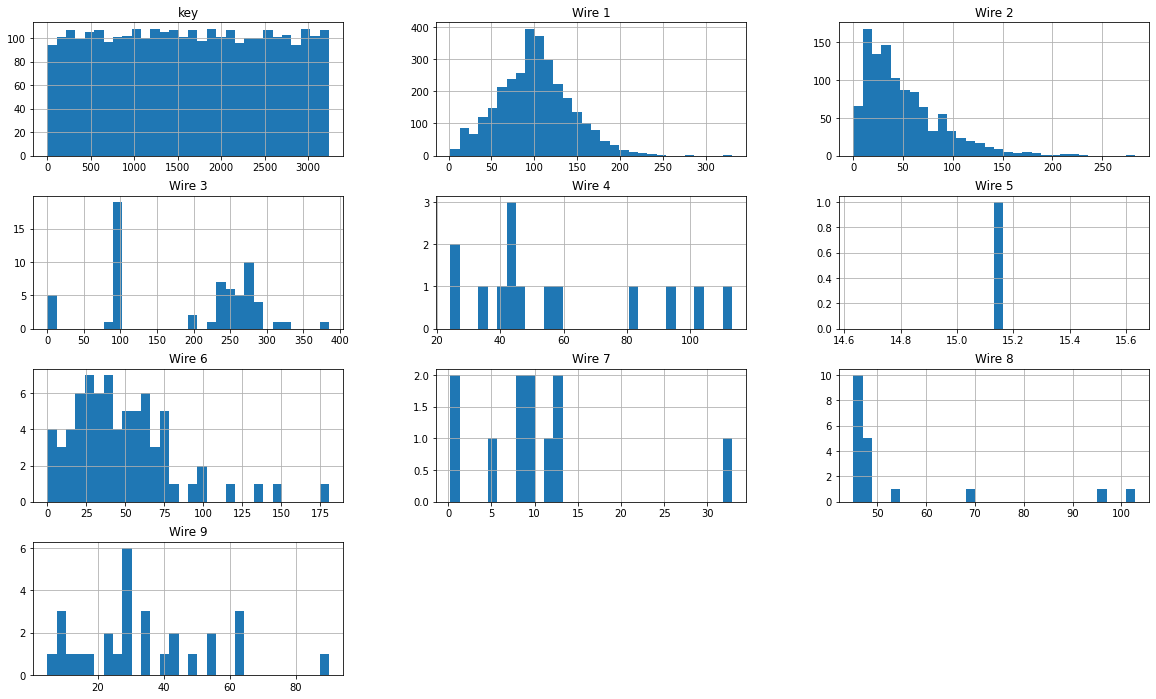

In [61]:
data_wire.hist(figsize=(20,12), bins=30)

<AxesSubplot:>

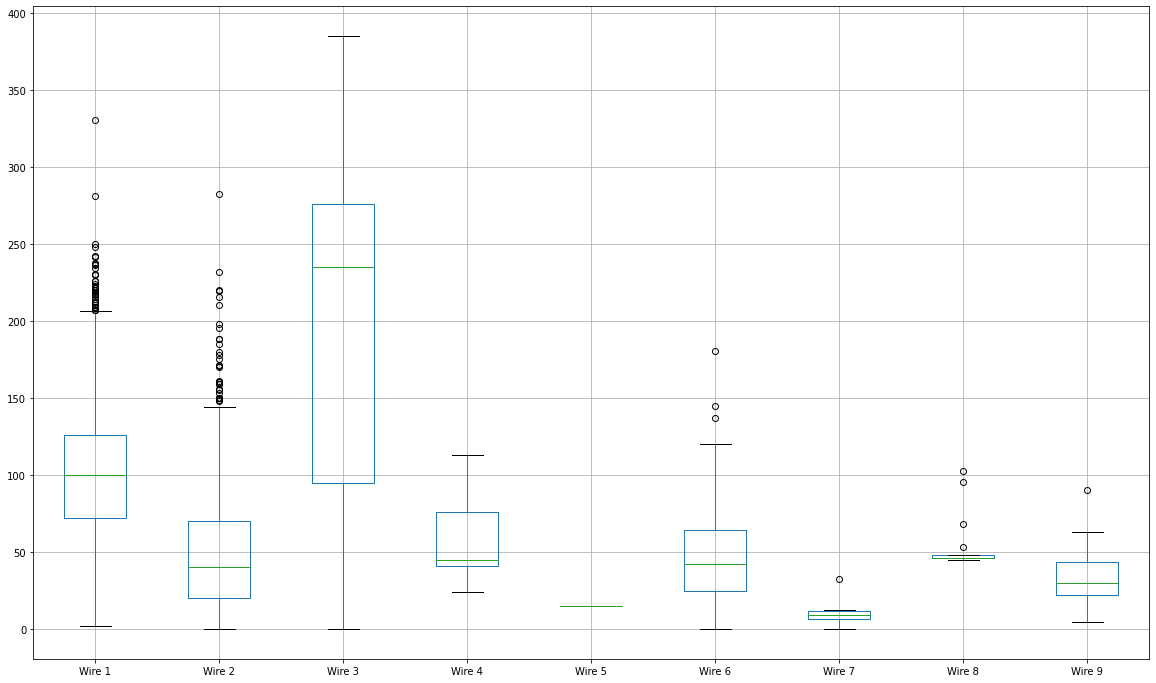

In [62]:
data_wire.drop(['key'], axis=1).boxplot(figsize=(20,12))

Аналогично таблице data_bulk - пропуски значит 0. Есть подозрения на явные выбросы.

In [63]:
data = pd.merge(data, data_wire, on='key')

In [64]:
data

,key,temp_target,temp_feature,a_power,r_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1613.0,1571.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1602.0,1581.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1599.0,1596.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1625.0,1601.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1602.0,1576.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,2495,1591.0,1570.0,3.210690,2.360777,0.0,0.0,21.0,0.0,0.0,...,7.125735,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1801,2496,1591.0,1554.0,4.203064,2.810185,0.0,0.0,0.0,63.0,0.0,...,9.412616,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1802,2497,1589.0,1571.0,2.212379,1.851269,0.0,0.0,0.0,85.0,0.0,...,6.271699,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1803,2498,1594.0,1591.0,3.408725,2.355428,0.0,0.0,90.0,0.0,0.0,...,14.953657,118.110717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1804
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           1805 non-null   int64  
 1   temp_target   1805 non-null   float64
 2   temp_feature  1805 non-null   float64
 3   a_power       1805 non-null   float64
 4   r_power       1805 non-null   float64
 5   Bulk 1        1805 non-null   float64
 6   Bulk 2        1805 non-null   float64
 7   Bulk 3        1805 non-null   float64
 8   Bulk 4        1805 non-null   float64
 9   Bulk 5        1805 non-null   float64
 10  Bulk 6        1805 non-null   float64
 11  Bulk 7        1805 non-null   float64
 12  Bulk 8        1805 non-null   float64
 13  Bulk 9        1805 non-null   float64
 14  Bulk 10       1805 non-null   float64
 15  Bulk 11       1805 non-null   float64
 16  Bulk 12       1805 non-null   float64
 17  Bulk 13       1805 non-null   float64
 18  Bulk 14       1805 non-null 

После чистки данных, есть пустые столбцы. Удалим их

In [66]:
data = data.drop(['Wire 4', 'Wire 5', 'Wire 7', 'key'], axis=1)
data = data.fillna(0)

In [67]:
data.duplicated().sum()

0

Дубликатов нет

In [68]:
data.head()

,temp_target,temp_feature,a_power,r_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 13,Bulk 14,Bulk 15,gas,Wire 1,Wire 2,Wire 3,Wire 6,Wire 8,Wire 9
0,1613.0,1571.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0
1,1602.0,1581.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0
2,1599.0,1596.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0
3,1625.0,1601.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,0.0,...,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0
4,1602.0,1576.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,...,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0


Итого 1805 партий и 25 признаков.

### Вывод

Изучив данные, можно сказать следующее.

Целевой признак - последнее значение температуры по партии. Необходимо удалить из температуры партии с выбросами, чтобы целевой признак был максимально "чистым". Партии, которые вызывают подозрения, необходимо будет проверить после удаления выбросов из температуры. Возможно, партии с выбросами уйдут.

В таблицах data_bulk и data_wire много пустых ячеек. Это значит, что в определенный момент просто не добавляллись дополнительные материалы. Пропуски необходимо заменить на 0. Если дополнительные матриалы не добавлялись, убрать такие партии - иначе у них не будет признаков.

Партии без измерения температуры, или с одним измерением температуры, так же необходимо удалить из датасета.

План работы над проектом был следующий :

**1)** Выделить целевой признак в отделную таблицу.

**2)** Объеденить таблицы по столбцу "key" и выполнить вышеперечисленные действия для подготовки данных.

**3)** Заполнить пропуски, удалить дубликаты.

**4)** Разделить данные на признаки и целевой признак.

**5)** Подобрать оптимальную модель на тренировочной выборке и добиться необходимых результатов МАЕ.

**6)** Протестировать лучшую модель на тестовой выборке, при необходимости доработать модель.

Шаги 1-3 выполнены. Переходим к построению модели.

## Построение модели 

In [69]:
features = data.drop('temp_target', axis=1)
target = data['temp_target']
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=20220809)


In [70]:
data

,temp_target,temp_feature,a_power,r_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 13,Bulk 14,Bulk 15,gas,Wire 1,Wire 2,Wire 3,Wire 6,Wire 8,Wire 9
0,1613.0,1571.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0
1,1602.0,1581.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0
2,1599.0,1596.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0
3,1625.0,1601.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,0.0,...,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0
4,1602.0,1576.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,...,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,1591.0,1570.0,3.210690,2.360777,0.0,0.0,21.0,0.0,0.0,0.0,...,0.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0
1801,1591.0,1554.0,4.203064,2.810185,0.0,0.0,0.0,63.0,0.0,0.0,...,0.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0
1802,1589.0,1571.0,2.212379,1.851269,0.0,0.0,0.0,85.0,0.0,0.0,...,0.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0
1803,1594.0,1591.0,3.408725,2.355428,0.0,0.0,90.0,0.0,0.0,0.0,...,0.0,129.0,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0


### LightGBM

In [71]:
def objective(trial, data=features_train, target=target_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20220809)
    
    params = {
        'metric': 'mae', 
        'random_state': 20220809,
        'n_estimators': 10000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.75,0.8,0.85]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.65,0.7,0.75,0.8,0.85]),
        'learning_rate': trial.suggest_categorical('learning_rate', 
                                                   [0.005,0.006,0.008,0.01,0.015,0.02,0.03]),
        'max_depth': trial.suggest_categorical('max_depth', [-1,10,20]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
        'verbosity': -1
    }
    
    model = LGBMRegressor(**params)      
    model.fit(X_train, y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=300, verbose=False)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    
    
    return mae

In [75]:
%%time

study = optuna.create_study(direction='minimize')  
study.optimize(objective, n_trials=30, show_progress_bar=True)           


print('Последняя итерация:', len(study.trials))
print('Лучшая итерация:', study.best_trial.params)
print('Лучшая ошибка:', study.best_trial.value)

[I 2022-08-13 05:57:51,024] A new study created in memory with name: no-name-d9a721f9-5635-412e-8e17-cae24d2072c7
/opt/conda/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:57:52,654] Trial 0 finished with value: 6.934856046641276 and parameters: {'reg_alpha': 1.236539188755706, 'reg_lambda': 0.001215807509715712, 'colsample_bytree': 0.8, 'subsample': 0.75, 'learning_rate': 0.02, 'max_depth': -1, 'num_leaves': 183, 'min_child_samples': 282, 'min_data_per_groups': 68}. Best is trial 0 with value: 6.934856046641276.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:57:59,650] Trial 1 finished with value: 6.2024992755957085 and parameters: {'reg_alpha': 0.08209901953651394, 'reg_lambda': 0.50739269782592, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': -1, 'num_leaves': 159, 'min_child_samples': 59, 'min_data_per_groups': 20}. Best is trial 1 with value: 6.2024992755957085.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:58:07,443] Trial 2 finished with value: 6.486065654880495 and parameters: {'reg_alpha': 0.5784171265343049, 'reg_lambda': 8.795037503369578, 'colsample_bytree': 0.35, 'subsample': 0.75, 'learning_rate': 0.008, 'max_depth': -1, 'num_leaves': 214, 'min_child_samples': 163, 'min_data_per_groups': 51}. Best is trial 1 with value: 6.2024992755957085.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:58:14,546] Trial 3 finished with value: 6.8470050584119395 and parameters: {'reg_alpha': 0.0018439623438496074, 'reg_lambda': 0.010420421925283373, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 103, 'min_child_samples': 236, 'min_data_per_groups': 33}. Best is trial 1 with value: 6.2024992755957085.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:58:18,940] Trial 4 finished with value: 6.880695855948261 and parameters: {'reg_alpha': 1.1148687249766025, 'reg_lambda': 0.0532134609426161, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.005, 'max_depth': -1, 'num_leaves': 278, 'min_child_samples': 237, 'min_data_per_groups': 14}. Best is trial 1 with value: 6.2024992755957085.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:58:24,456] Trial 5 finished with value: 6.040093433681928 and parameters: {'reg_alpha': 0.10293757785242086, 'reg_lambda': 0.039975795400497414, 'colsample_bytree': 0.45, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 5, 'min_child_samples': 12, 'min_data_per_groups': 12}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:58:28,039] Trial 6 finished with value: 6.949207470420172 and parameters: {'reg_alpha': 0.17413277109866265, 'reg_lambda': 0.006559556490475512, 'colsample_bytree': 0.45, 'subsample': 0.65, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 104, 'min_child_samples': 266, 'min_data_per_groups': 35}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:58:37,248] Trial 7 finished with value: 6.850725157002629 and parameters: {'reg_alpha': 0.00923974319911821, 'reg_lambda': 0.026491470035269374, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 188, 'min_child_samples': 225, 'min_data_per_groups': 42}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:58:48,145] Trial 8 finished with value: 6.482649270823018 and parameters: {'reg_alpha': 0.28770098825523105, 'reg_lambda': 5.302003555581401, 'colsample_bytree': 0.45, 'subsample': 0.65, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 242, 'min_child_samples': 185, 'min_data_per_groups': 72}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:58:51,252] Trial 9 finished with value: 6.764818220471015 and parameters: {'reg_alpha': 6.1180743906323825, 'reg_lambda': 5.312102301373152, 'colsample_bytree': 0.3, 'subsample': 0.65, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 221, 'min_child_samples': 219, 'min_data_per_groups': 25}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:59:01,651] Trial 10 finished with value: 6.17192203970539 and parameters: {'reg_alpha': 0.019146507703132157, 'reg_lambda': 0.3239291646308357, 'colsample_bytree': 0.4, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 10, 'num_leaves': 11, 'min_child_samples': 7, 'min_data_per_groups': 8}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:59:14,844] Trial 11 finished with value: 6.101860854175968 and parameters: {'reg_alpha': 0.023786438764044467, 'reg_lambda': 0.21455733900155197, 'colsample_bytree': 0.4, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 10, 'num_leaves': 5, 'min_child_samples': 13, 'min_data_per_groups': 3}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:59:16,644] Trial 12 finished with value: 6.142375441114752 and parameters: {'reg_alpha': 0.03310240373283981, 'reg_lambda': 0.2604453312091067, 'colsample_bytree': 0.85, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 10, 'num_leaves': 5, 'min_child_samples': 83, 'min_data_per_groups': 96}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:59:24,249] Trial 13 finished with value: 6.25002756784073 and parameters: {'reg_alpha': 0.0043407012907080425, 'reg_lambda': 1.1082941677089921, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.015, 'max_depth': 10, 'num_leaves': 61, 'min_child_samples': 27, 'min_data_per_groups': 2}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:59:28,461] Trial 14 finished with value: 6.237903131873324 and parameters: {'reg_alpha': 0.060123864568104556, 'reg_lambda': 0.09401575011045825, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 46, 'min_child_samples': 101, 'min_data_per_groups': 6}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:59:32,961] Trial 15 finished with value: 6.315734373537808 and parameters: {'reg_alpha': 0.01100616109087294, 'reg_lambda': 0.02127497255361867, 'colsample_bytree': 0.7, 'subsample': 0.85, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 69, 'min_child_samples': 107, 'min_data_per_groups': 53}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:59:36,246] Trial 16 finished with value: 6.200336429602279 and parameters: {'reg_alpha': 0.00264314846429301, 'reg_lambda': 1.637713745526349, 'colsample_bytree': 0.45, 'subsample': 0.8, 'learning_rate': 0.03, 'max_depth': -1, 'num_leaves': 116, 'min_child_samples': 49, 'min_data_per_groups': 21}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:59:46,747] Trial 17 finished with value: 6.130028366694758 and parameters: {'reg_alpha': 0.0382067846482388, 'reg_lambda': 0.0019065754676629426, 'colsample_bytree': 0.75, 'subsample': 0.85, 'learning_rate': 0.015, 'max_depth': -1, 'num_leaves': 33, 'min_child_samples': 2, 'min_data_per_groups': 2}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 05:59:54,054] Trial 18 finished with value: 6.378573841510229 and parameters: {'reg_alpha': 0.0010316996169793479, 'reg_lambda': 0.12966841422512773, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.005, 'max_depth': 10, 'num_leaves': 81, 'min_child_samples': 122, 'min_data_per_groups': 65}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:00:00,443] Trial 19 finished with value: 6.086981589051092 and parameters: {'reg_alpha': 0.1366702804507097, 'reg_lambda': 0.004194504037728188, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 29, 'min_child_samples': 55, 'min_data_per_groups': 97}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:00:08,440] Trial 20 finished with value: 6.085440279144154 and parameters: {'reg_alpha': 5.346220218535277, 'reg_lambda': 0.0035929059225024334, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 131, 'min_child_samples': 55, 'min_data_per_groups': 99}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:00:18,154] Trial 21 finished with value: 6.074983262633698 and parameters: {'reg_alpha': 8.0554512722167, 'reg_lambda': 0.004075784787963394, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 140, 'min_child_samples': 52, 'min_data_per_groups': 100}. Best is trial 5 with value: 6.040093433681928.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:00:28,443] Trial 22 finished with value: 6.034621449876158 and parameters: {'reg_alpha': 9.33033899064523, 'reg_lambda': 0.0029770972261161373, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 141, 'min_child_samples': 34, 'min_data_per_groups': 85}. Best is trial 22 with value: 6.034621449876158.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:00:43,239] Trial 23 finished with value: 6.0102901236981445 and parameters: {'reg_alpha': 8.458320095773818, 'reg_lambda': 0.016642380277338525, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 155, 'min_child_samples': 27, 'min_data_per_groups': 79}. Best is trial 23 with value: 6.0102901236981445.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:00:55,944] Trial 24 finished with value: 6.004900462344114 and parameters: {'reg_alpha': 3.288713759353438, 'reg_lambda': 0.019900510078570535, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 160, 'min_child_samples': 31, 'min_data_per_groups': 81}. Best is trial 24 with value: 6.004900462344114.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:01:01,049] Trial 25 finished with value: 6.155222278784089 and parameters: {'reg_alpha': 2.3751479910845554, 'reg_lambda': 0.012767141163085166, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 164, 'min_child_samples': 79, 'min_data_per_groups': 80}. Best is trial 24 with value: 6.004900462344114.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:01:18,655] Trial 26 finished with value: 6.035904494363048 and parameters: {'reg_alpha': 2.7229787722005527, 'reg_lambda': 0.01280372144359936, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 186, 'min_child_samples': 32, 'min_data_per_groups': 86}. Best is trial 24 with value: 6.004900462344114.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:01:24,140] Trial 27 finished with value: 6.166500204038843 and parameters: {'reg_alpha': 2.3605885867952607, 'reg_lambda': 0.0010533976119699525, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 152, 'min_child_samples': 82, 'min_data_per_groups': 83}. Best is trial 24 with value: 6.004900462344114.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:01:34,444] Trial 28 finished with value: 6.451840036464885 and parameters: {'reg_alpha': 3.8454231612465226, 'reg_lambda': 0.05709115772438323, 'colsample_bytree': 0.35, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 126, 'min_child_samples': 147, 'min_data_per_groups': 61}. Best is trial 24 with value: 6.004900462344114.


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-08-13 06:01:46,743] Trial 29 finished with value: 6.079219746457064 and parameters: {'reg_alpha': 1.0354450162680566, 'reg_lambda': 0.002463415122505307, 'colsample_bytree': 0.6, 'subsample': 0.75, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 174, 'min_child_samples': 35, 'min_data_per_groups': 75}. Best is trial 24 with value: 6.004900462344114.
Последняя итерация: 30
Лучшая итерация: {'reg_alpha': 3.288713759353438, 'reg_lambda': 0.019900510078570535, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 160, 'min_child_samples': 31, 'min_data_per_groups': 81}
Лучшая ошибка: 6.004900462344114
CPU times: user 3min 47s, sys: 2.09 s, total: 3min 49s
Wall time: 3min 55s


In [76]:
optuna_params = study.best_params

optuna_params['metric'] = 'mae'
optuna_params['random_state'] = 20220809
optuna_params['n_estimators'] = 10000

In [77]:
X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, test_size=0.2, random_state=20220809)

model_optuna_LGBM = LGBMRegressor(**optuna_params)
model_optuna_LGBM.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=300, verbose=300)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[300]	valid_0's l1: 6.42108
[600]	valid_0's l1: 6.10575
[900]	valid_0's l1: 6.01182
[1200]	valid_0's l1: 6.00668


LGBMRegressor(colsample_bytree=0.85, learning_rate=0.006, metric='mae',
              min_child_samples=31, min_data_per_groups=81, n_estimators=10000,
              num_leaves=160, random_state=20220809,
              reg_alpha=3.288713759353438, reg_lambda=0.019900510078570535,
              subsample=0.7)

### XGBoost

In [78]:
def objective(trial, data=features, target=target):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2, random_state=20220809)
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [20220809]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
        
    }
    model =XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)], early_stopping_rounds=100, verbose=300)
    
    preds = model.predict(test_x)
    
    mae = mean_absolute_error(test_y, preds)
    
    return mae

print('Последняя итерация:', len(study.trials))
print('Лучшая итерация:', study.best_trial.params)
study = optuna.create_study(direction='minimize') 
study.optimize(objective, n_trials=10, show_progress_bar=True)

optuna_params = study.best_params
optuna_params['metric'] = 'mae'
optuna_params['random_state'] = 20220809
optuna_params['n_estimators'] = 10000

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=20220809)
model_optuna = XGBRegressor(**optuna_params)
model_optuna.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=300, verbose=300)

[I 2022-08-13 06:02:45,818] A new study created in memory with name: no-name-9fd3a845-f269-4c76-8519-ab1ff4129ac8


Последняя итерация: 30
Лучшая итерация: {'reg_alpha': 3.288713759353438, 'reg_lambda': 0.019900510078570535, 'colsample_bytree': 0.85, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': -1, 'num_leaves': 160, 'min_child_samples': 31, 'min_data_per_groups': 81}


/opt/conda/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[0]	validation_0-rmse:1580.93005
[300]	validation_0-rmse:142.14598
[600]	validation_0-rmse:15.57293
[900]	validation_0-rmse:9.14825
[1200]	validation_0-rmse:9.03350
[1500]	validation_0-rmse:8.99815
[1800]	validation_0-rmse:8.97542
[2100]	validation_0-rmse:8.95811
[2400]	validation_0-rmse:8.94904
[2700]	validation_0-rmse:8.94195
[2922]	validation_0-rmse:8.93716
[I 2022-08-13 06:04:36,472] Trial 0 finished with value: 6.804336167438539 and parameters: {'lambda': 0.005663075848839065, 'alpha': 0.005126455755877082, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 9, 'random_state': 20220809, 'min_child_weight': 244}. Best is trial 0 with value: 6.804336167438539.
[0]	validation_0-rmse:1561.80481
[300]	validation_0-rmse:9.66290
[600]	validation_0-rmse:8.92713
[900]	validation_0-rmse:8.87749
[1036]	validation_0-rmse:8.87307
[I 2022-08-13 06:05:19,714] Trial 1 finished with value: 6.76306186158241 and parameters: {'lambda': 0.0011089544297555552, 'alpha': 0.107

XGBRegressor(alpha=0.0014244203235632032, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=0.024330903539520624,
             learning_rate=0.014, max_delta_step=0, max_depth=15, metric='mae',
             min_child_weight=78, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1,
             predictor='auto', random_state=20220809, reg_alpha=0.00142442028,
             reg_lambda=0.0243309028, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, ...)

### CatBoost

In [79]:
def objective(trial,data=features_test,target=target_test):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2, random_state=20220809)
    param = {
        'loss_function': 'MAE',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':  25000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
        'random_state': trial.suggest_categorical('random_state', [20220809]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }
    model = CatBoostRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=200,verbose=300)
    
    preds = model.predict(test_x)
    
    mae = mean_absolute_error(test_y, preds)
    
    return mae

In [285]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Последняя итерация:', len(study.trials))
print('Лучшая итерация:', study.best_trial.params)

[I 2022-08-13 00:12:54,449] A new study created in memory with name: no-name-c1b8bd3b-7f70-428e-a79a-a280bc7c0836


0:	learn: 8.1415413	test: 6.8931518	best: 6.8931518 (0)	total: 37.4ms	remaining: 15m 33s
300:	learn: 2.0279794	test: 5.5914235	best: 5.5913772 (298)	total: 10.8s	remaining: 14m 46s
600:	learn: 0.9096126	test: 5.5467640	best: 5.5292106 (507)	total: 21.8s	remaining: 14m 44s


[I 2022-08-13 00:13:20,389] Trial 0 finished with value: 5.529211600209025 and parameters: {'l2_leaf_reg': 0.24092551943126014, 'max_bin': 287, 'bagging_fraction': 0.7605269471592788, 'learning_rate': 0.01104551440418857, 'max_depth': 11, 'random_state': 20220809, 'min_data_in_leaf': 248}. Best is trial 0 with value: 5.529211600209025.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.5292106
bestIteration = 507

Shrink model to first 508 iterations.
0:	learn: 8.1845546	test: 6.9065621	best: 6.9065621 (0)	total: 14.5ms	remaining: 6m 1s
300:	learn: 5.0447150	test: 5.5077105	best: 5.5077105 (300)	total: 395ms	remaining: 32.4s
600:	learn: 4.0416758	test: 5.2815677	best: 5.2792951 (547)	total: 737ms	remaining: 29.9s
900:	learn: 3.3492943	test: 5.2687442	best: 5.2644625 (889)	total: 1.08s	remaining: 28.8s


[I 2022-08-13 00:13:21,953] Trial 1 finished with value: 5.264463488962015 and parameters: {'l2_leaf_reg': 0.6568166467156822, 'max_bin': 325, 'bagging_fraction': 0.7766815243197784, 'learning_rate': 0.010697003986882597, 'max_depth': 5, 'random_state': 20220809, 'min_data_in_leaf': 3}. Best is trial 1 with value: 5.264463488962015.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.264462489
bestIteration = 889

Shrink model to first 890 iterations.
0:	learn: 8.1456085	test: 6.8972641	best: 6.8972641 (0)	total: 136ms	remaining: 56m 31s
300:	learn: 1.4602769	test: 5.8882496	best: 5.8844745 (295)	total: 39.9s	remaining: 54m 32s
600:	learn: 0.4324280	test: 5.8556789	best: 5.8478966 (558)	total: 1m 20s	remaining: 54m 37s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.847896554
bestIteration = 558

Shrink model to first 559 iterations.


[I 2022-08-13 00:15:05,220] Trial 2 finished with value: 5.847897553978383 and parameters: {'l2_leaf_reg': 0.0012649420083355625, 'max_bin': 264, 'bagging_fraction': 0.5010922333596879, 'learning_rate': 0.010621098711794525, 'max_depth': 13, 'random_state': 20220809, 'min_data_in_leaf': 137}. Best is trial 1 with value: 5.264463488962015.


0:	learn: 8.1708466	test: 6.9011924	best: 6.9011924 (0)	total: 32.1ms	remaining: 13m 22s
300:	learn: 2.8606451	test: 5.7275895	best: 5.7266928 (299)	total: 9.34s	remaining: 12m 46s
600:	learn: 1.5376648	test: 5.5454119	best: 5.5443755 (592)	total: 18.6s	remaining: 12m 34s
900:	learn: 0.9790905	test: 5.5153487	best: 5.5141833 (897)	total: 28s	remaining: 12m 29s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.511417079
bestIteration = 904

Shrink model to first 905 iterations.


[I 2022-08-13 00:15:40,179] Trial 3 finished with value: 5.511418079073337 and parameters: {'l2_leaf_reg': 0.24116321816853475, 'max_bin': 232, 'bagging_fraction': 0.9386119834503293, 'learning_rate': 0.007343717309167884, 'max_depth': 11, 'random_state': 20220809, 'min_data_in_leaf': 191}. Best is trial 1 with value: 5.264463488962015.


0:	learn: 8.0901277	test: 6.8958950	best: 6.8958950 (0)	total: 581ms	remaining: 4h 2m 5s
300:	learn: 0.4441782	test: 5.8246155	best: 5.8219821 (295)	total: 2m 47s	remaining: 3h 48m 53s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.816272821
bestIteration = 376

Shrink model to first 377 iterations.


[I 2022-08-13 00:21:14,761] Trial 4 finished with value: 5.816273820725535 and parameters: {'l2_leaf_reg': 0.0028949829536499528, 'max_bin': 310, 'bagging_fraction': 0.4872172745417047, 'learning_rate': 0.016191899058498258, 'max_depth': 15, 'random_state': 20220809, 'min_data_in_leaf': 281}. Best is trial 1 with value: 5.264463488962015.


0:	learn: 8.1496018	test: 6.8989903	best: 6.8989903 (0)	total: 38.6ms	remaining: 16m 6s
300:	learn: 1.7453591	test: 5.7367912	best: 5.7367912 (300)	total: 10.7s	remaining: 14m 40s
600:	learn: 0.7000057	test: 5.7013993	best: 5.6875910 (487)	total: 21.6s	remaining: 14m 36s


[I 2022-08-13 00:21:39,852] Trial 5 finished with value: 5.687591972081196 and parameters: {'l2_leaf_reg': 0.0055458626956876676, 'max_bin': 273, 'bagging_fraction': 0.5820728746678817, 'learning_rate': 0.012545173795154166, 'max_depth': 11, 'random_state': 20220809, 'min_data_in_leaf': 289}. Best is trial 1 with value: 5.264463488962015.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.687590972
bestIteration = 487

Shrink model to first 488 iterations.
0:	learn: 8.1844277	test: 6.9012707	best: 6.9012707 (0)	total: 5.65ms	remaining: 2m 21s
300:	learn: 4.9251113	test: 5.4044434	best: 5.3998110 (298)	total: 352ms	remaining: 28.9s
600:	learn: 3.8920399	test: 5.2040558	best: 5.2008428 (597)	total: 701ms	remaining: 28.5s
900:	learn: 3.2240937	test: 5.1863243	best: 5.1788123 (871)	total: 1.07s	remaining: 28.7s
1200:	learn: 2.7942343	test: 5.1589975	best: 5.1552181 (1156)	total: 1.42s	remaining: 28.1s
Stopped by overfitting detector  (200 iterations wait)


[I 2022-08-13 00:21:41,637] Trial 6 finished with value: 5.1552190573540235 and parameters: {'l2_leaf_reg': 7.561192644476595, 'max_bin': 322, 'bagging_fraction': 0.7374138744681633, 'learning_rate': 0.011717591700965608, 'max_depth': 5, 'random_state': 20220809, 'min_data_in_leaf': 270}. Best is trial 6 with value: 5.1552190573540235.



bestTest = 5.155218057
bestIteration = 1156

Shrink model to first 1157 iterations.
0:	learn: 8.1909752	test: 6.9035416	best: 6.9035416 (0)	total: 11.5ms	remaining: 4m 48s
300:	learn: 5.2311419	test: 5.5283788	best: 5.5244733 (294)	total: 315ms	remaining: 25.8s
600:	learn: 4.1733566	test: 5.2777740	best: 5.2741361 (586)	total: 605ms	remaining: 24.6s
900:	learn: 3.4968387	test: 5.2449659	best: 5.2402976 (832)	total: 899ms	remaining: 24s
1200:	learn: 3.0679539	test: 5.2255444	best: 5.2227739 (1065)	total: 1.26s	remaining: 24.9s
1500:	learn: 2.7553841	test: 5.2093909	best: 5.2072740 (1373)	total: 1.64s	remaining: 25.6s
1800:	learn: 2.5314479	test: 5.1986286	best: 5.1939302 (1726)	total: 1.96s	remaining: 25.3s


[I 2022-08-13 00:21:44,322] Trial 7 finished with value: 5.187520133207697 and parameters: {'l2_leaf_reg': 0.009388788061375981, 'max_bin': 230, 'bagging_fraction': 0.5432410813550062, 'learning_rate': 0.00996954115902303, 'max_depth': 5, 'random_state': 20220809, 'min_data_in_leaf': 258}. Best is trial 6 with value: 5.1552190573540235.


2100:	learn: 2.3330573	test: 5.1955486	best: 5.1875191 (2003)	total: 2.28s	remaining: 24.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.187519133
bestIteration = 2003

Shrink model to first 2004 iterations.
0:	learn: 8.1322305	test: 6.8909366	best: 6.8909366 (0)	total: 191ms	remaining: 1h 19m 28s
300:	learn: 1.1682968	test: 5.7708328	best: 5.7694263 (299)	total: 49.6s	remaining: 1h 7m 54s
600:	learn: 0.3594688	test: 5.7278634	best: 5.7246783 (517)	total: 1m 37s	remaining: 1h 5m 55s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.720464044
bestIteration = 684

Shrink model to first 685 iterations.


[I 2022-08-13 00:24:08,853] Trial 8 finished with value: 5.720465043619289 and parameters: {'l2_leaf_reg': 0.0031305263036679994, 'max_bin': 393, 'bagging_fraction': 0.700329047106022, 'learning_rate': 0.01218149491665305, 'max_depth': 13, 'random_state': 20220809, 'min_data_in_leaf': 53}. Best is trial 6 with value: 5.1552190573540235.


0:	learn: 8.1360476	test: 6.8877858	best: 6.8877858 (0)	total: 15.9ms	remaining: 6m 37s
300:	learn: 2.1653264	test: 5.4224485	best: 5.4138945 (294)	total: 2.19s	remaining: 2m 59s


[I 2022-08-13 00:24:12,872] Trial 9 finished with value: 5.386312571665195 and parameters: {'l2_leaf_reg': 2.0575644973618066, 'max_bin': 248, 'bagging_fraction': 0.9224161522929305, 'learning_rate': 0.01688089728439124, 'max_depth': 9, 'random_state': 20220809, 'min_data_in_leaf': 123}. Best is trial 6 with value: 5.1552190573540235.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.386311572
bestIteration = 335

Shrink model to first 336 iterations.
Последняя итерация: 10
Лучшая итерация: {'l2_leaf_reg': 7.561192644476595, 'max_bin': 322, 'bagging_fraction': 0.7374138744681633, 'learning_rate': 0.011717591700965608, 'max_depth': 5, 'random_state': 20220809, 'min_data_in_leaf': 270}


In [291]:
study.best_trial.params

{'l2_leaf_reg': 7.561192644476595,
 'max_bin': 322,
 'bagging_fraction': 0.7374138744681633,
 'learning_rate': 0.011717591700965608,
 'max_depth': 5,
 'random_state': 20220809,
 'min_data_in_leaf': 270}

Лушие параметры у CatBoost. Протестируем

In [294]:
model_cat = CatBoostRegressor(l2_leaf_reg= 7.561192644476595,
                              max_bin= 322,
                              #bagging_fraction= 0.7374138744681633,
                              learning_rate=0.011717591700965608,
                              max_depth= 5,
                              random_state= 20220809,
                              min_data_in_leaf= 270)

In [296]:
model_cat.fit(features_train, target_train)
mean_absolute_error(target_test, model_cat.predict(features_test))

0:	learn: 10.5486147	total: 2.19ms	remaining: 2.19s
1:	learn: 10.5184569	total: 4.15ms	remaining: 2.07s
2:	learn: 10.4919397	total: 6.04ms	remaining: 2.01s
3:	learn: 10.4643426	total: 7.96ms	remaining: 1.98s
4:	learn: 10.4365047	total: 9.69ms	remaining: 1.93s
5:	learn: 10.4073352	total: 11.6ms	remaining: 1.92s
6:	learn: 10.3730492	total: 13.4ms	remaining: 1.9s
7:	learn: 10.3452140	total: 15.2ms	remaining: 1.88s
8:	learn: 10.3179433	total: 17.4ms	remaining: 1.92s
9:	learn: 10.2893263	total: 19.2ms	remaining: 1.9s
10:	learn: 10.2582404	total: 21.1ms	remaining: 1.9s
11:	learn: 10.2297487	total: 22.9ms	remaining: 1.89s
12:	learn: 10.2024187	total: 24.7ms	remaining: 1.87s
13:	learn: 10.1779787	total: 26.5ms	remaining: 1.87s
14:	learn: 10.1481815	total: 28.2ms	remaining: 1.85s
15:	learn: 10.1249108	total: 29.9ms	remaining: 1.84s
16:	learn: 10.0995654	total: 31.7ms	remaining: 1.83s
17:	learn: 10.0775303	total: 33.5ms	remaining: 1.82s
18:	learn: 10.0552141	total: 35.3ms	remaining: 1.82s
19:	le

5.936650912743989

In [295]:
scores = cross_val_score(model_cat, features_train, target_train, scoring='neg_mean_absolute_error')
print(scores)
print(scores.mean())

0:	learn: 10.5219381	total: 17.3ms	remaining: 17.3s
1:	learn: 10.4931076	total: 19.4ms	remaining: 9.68s
2:	learn: 10.4653333	total: 21.2ms	remaining: 7.05s
3:	learn: 10.4369821	total: 23ms	remaining: 5.72s
4:	learn: 10.4082090	total: 24.7ms	remaining: 4.91s
5:	learn: 10.3770755	total: 26.3ms	remaining: 4.36s
6:	learn: 10.3493302	total: 28ms	remaining: 3.98s
7:	learn: 10.3257875	total: 29.7ms	remaining: 3.68s
8:	learn: 10.3051404	total: 31.3ms	remaining: 3.45s
9:	learn: 10.2775298	total: 33ms	remaining: 3.26s
10:	learn: 10.2492117	total: 34.6ms	remaining: 3.11s
11:	learn: 10.2249566	total: 36.2ms	remaining: 2.98s
12:	learn: 10.2023614	total: 38.1ms	remaining: 2.89s
13:	learn: 10.1796400	total: 39.8ms	remaining: 2.81s
14:	learn: 10.1514689	total: 41.6ms	remaining: 2.73s
15:	learn: 10.1291332	total: 43.2ms	remaining: 2.66s
16:	learn: 10.1040014	total: 45.1ms	remaining: 2.61s
17:	learn: 10.0838013	total: 46.7ms	remaining: 2.55s
18:	learn: 10.0639060	total: 48.4ms	remaining: 2.5s
19:	learn:

### Визуализация важных признаков

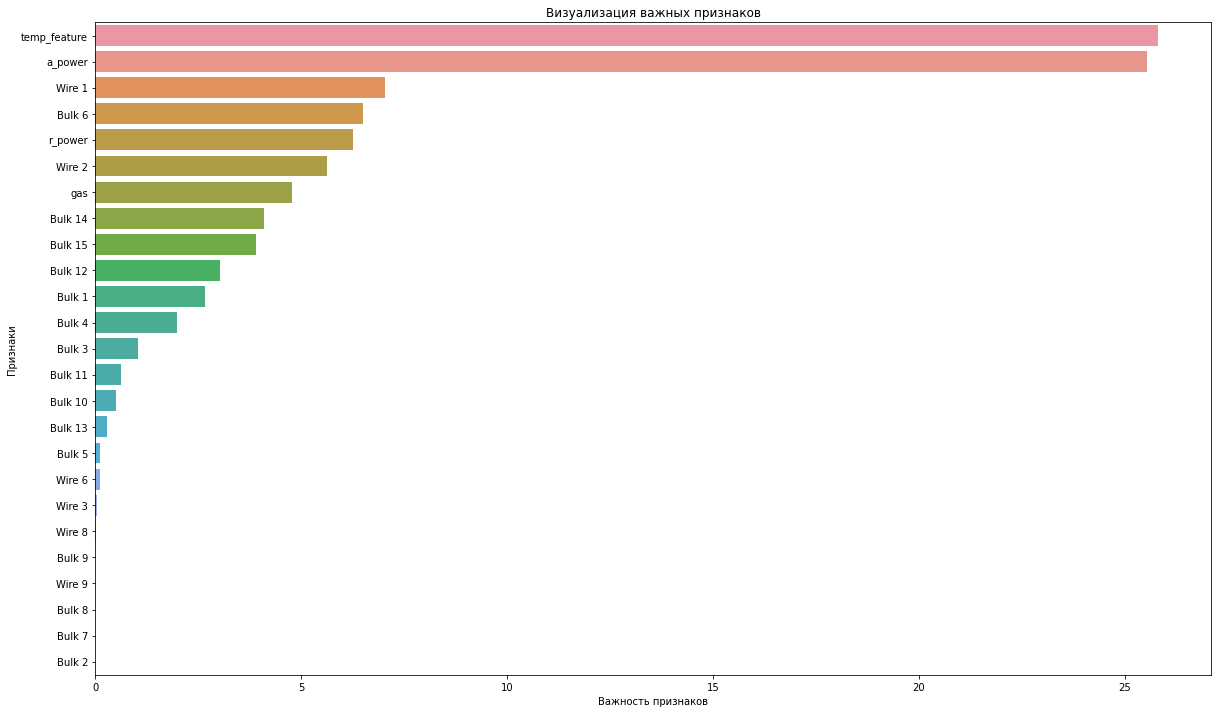

In [274]:
feature_names = features.columns
feature_imp = pd.Series(model_cat.feature_importances_,index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(20, 12))
seaborn.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

Возможно, если убрать бесполезные признаки, можно еще уменьшить ошибку.

## Вывод

Изначальный набор данных был разделен на несколько таблиц. Необходимо было обработать данные, основная проблемы заключалась в выбросах. Сначала проанализиролвали данные о температуре. После удаления выбросов и объединения таблиц по ключу партии, большинство выбросов ушло. Набор данных уменьшился почти в 2 раза.

Было протестировано три модели: LightGBM, XGBoost и CatBoost. Первые две обучились довольно быстро. Но не смотря на долго обучение, у CatBoost получились лучшие результаты. При обучении это МАЕ=5.386, при тестировании МАЕ=5.936. 

Если обратить внимание на важность признаков при обучении, то видно, что 7 признаков очень мало повлияли на обучение. Возможно, если их убрать, модель покажет еще лучший результат.

## Отчет по решению

В данном проекте задача заключалась в следующем - разработать предсказательную модель температуры расплавленного состояния сплава, которая поспособствует бизнесу в работе над своими издержками. 

Метрика качества модели - MAE (mean absolute error). Входные данные состояли из 7 таблиц.

План работы над проектом состоял из нескольких шагов:

**1)** Выделить целевой признак в отделную таблицу.

**2)** Объеденить таблицы по столбцу "key" и выполнить вышеперечисленные действия для подготовки данных.

**3)** Заполнить пропуски, удалить дубликаты.

**4)** Разделить данные на признаки и целевой признак.

**5)** Подобрать оптимальную модель на тренировочной выборке и добиться необходимых результатов МАЕ.

**6)** Протестировать лучшую модель на тестовой выборке, при необходимости доработать модель.

Когда я приступил к работе, я немного изменил план работы, поменяв пункты 3 и 1 местами. После окончательного ознакомления с данными, план был скорректирован и представлял собой следующее:

**1)** Обработать данные - избавиться от выбросов, заполнить пропуски, удалить дубликаты.

**2)** Объеденить таблицы по столбцу "key".

**3)** Разделить данные на признаки и целевой признак.

**4)** Подобрать оптимальную модель на тренировочной выборке и добиться необходимых результатов МАЕ.

**5)** Протестировать лучшую модель на тестовой выборке, при необходимости доработать модель.

Главной особенностью данных было то, что было много выбросов и пропусков. Нужно было избавиться от выбросов в целевом признаке. И удалить не просто строки, а именно партии, в которых есть выбросы. Для того, чтобы оставить максимально приближенные к реальности данные, выбросы в диапазоне от **q_3 + 1.5irq** до **q_3 + 3irq**, где q_3 - верхняя квартиль, irq - интерквартильный размах, мы оставили.

После удаления выбросов, мы так же удалили партии, в которых только одно измерение температуры, и есть пропуски. Ведь заполнять целевой признак медианой или средним - это плохой вариант. После этого, мы начали изучать другие данные, в которых тоже были выбросы. Но после объединения таблиц по партиям, большинство выбросов ушли, осталось удалить лишь точечно пару партий. Итого, обработав данные и объеденив таблицы, проверив дубликаты и заполнив пропуски, осталось чуть больше половины входных данных. Этого досточно для обучения модели.

Далее мы приступили к шагу 3. Разедлил на признак и целевой признаки, на тренировочную и тестовую выбрки.

На 4 шаге, мы начали выбирать оптимальную модель. Так как от бизнеса не поступало четких рамок по времени обучения и главной целью было минимизироать МАЕ, было принято решение пользоваться бустингами - XGBoost, LightGBM и CatBoost. Для подбора гиперпараметров использовалась библиотека optuna. В процессе обучения, лучший результат получился у CatBoost: МАЕ=5.386, при тестировании МАЕ=5.936. После обучнения, при кросс-валидации ошибка получилась 5.814.

После обучние, мы вывели график с важностью признаков модели. И оказалось, что 7 признаков из 25 помогли обучению очень мало. И, возможно, после их удаления и обучения модели заново, результат получится еще лучше. Самым полезным признаком получилась первая температура по партии.

Итоговая модель предсказывает значение температуры расплавленного металла. Она должна помочь бизнесу в работе над своими издержками. Ведь, если знать, до какой температуры нужно будет греть ковш с металлом, не нужно будет греть его дольше для достижения результат. Тем самым, снижается не только расход электроэнергии, но и уменьшается износ оборудования, уменьшается время достижения результата. Это тоже экономия денег - можно будет реже делать техническое обслуживание оборудования, а сэкономленное время можно использовать для дополнительных процессов плавления, тем самым увеличив производительность предприятия.